# Data Selection for Modeling

This notebook loads the cleaned dataset, filters for entries with a populated Research_Type column, drops the mostly-empty Trial_Phase column, and provides a summary for modeling readiness.

In [51]:
import pandas as pd
from collections import Counter
from pprint import pprint       
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import pickle
import os
from typing import Dict, Optional
import json


# Load the cleaned data
df = pd.read_csv('cleaned_for_eda.csv')

# Keep only rows where Research_Type is populated (not null/empty)
df = df[df['Research_Type'].notnull() & (df['Research_Type'].str.strip() != '')].copy()

# Drop the Trial_Phase column
if 'Trial_Phase' in df.columns:
        df = df.drop(columns=['Trial_Phase'])

# Display basic info
print(f'Rows with Research_Type: {len(df)}')
print('Columns:', list(df.columns))
df.head()

Rows with Research_Type: 598
Columns: ['PMID', 'Title', 'Abstract', 'Journal', 'Year', 'Authors', 'Cleaned_Abstract', 'Categories', 'Research_Type', 'Diseases', 'Chemicals']


,PMID,Title,Abstract,Journal,Year,Authors,Cleaned_Abstract,Categories,Research_Type,Diseases,Chemicals
0,40603982,Barbigerone attenuates 3-nitropropionic acid-i...,"Huntington's Disease (HD), a neurodegenerative...",Scientific reports,2025.0,Sattam Khulaif Alenezi,huntington disease hd neurodegenerative diseas...,huntington's disease; hd; neurodegenerative di...,clinical_trial,huntington's disease; hd; neurodegenerative di...,barbigerone; malondialdehyde; mda; nitric oxid...
8,40590994,Comparative efficacy and safety of irreversibl...,"Parkinson's disease (PD) is a progressive, neu...",Journal of neurology,2025.0,Marwah Bintay Khalid; Faizan Shahzad; Momina R...,parkinson disease pd progressive neurodegenera...,parkinson's disease; pd; parkinson's disease r...,clinical_trial; review,parkinsons disease; parkinson's disease,safinamide; rasagiline; dopamine; smd
13,40577046,Corticospinal Intermittent Theta Burst Stimula...,Intermittent theta burst stimulation (iTBS) is...,JMIR research protocols,2025.0,Deeksha Patel; Rohit Banerjee; Kamran Farooque...,intermittent theta burst stimulation itbs noni...,cord injury; motor and sensory dysfunction; as...,clinical_trial,cord injury; motor deficit; asia; pain; anxiet...,NaN
18,40572513,Advances in the Exploration of Coordination Co...,Alzheimer's disease (AD) is a progressive neur...,"Molecules (Basel, Switzerland)",2025.0,Jesús Antonio Cruz-Navarro; Luis Humberto Delg...,alzheimer disease ad progressive neurodegenera...,alzheimer's disease; ad; neurodegenerative dis...,review,alzheimers disease; neurodegenerative disorder...,vanadium; oxovanadium; peroxovanadium; protein...
20,40567829,How Do Patients' Fear Prediction and Fear Expe...,Expectancy violation has been proposed as a po...,Depression and anxiety,2025.0,Marina Hilleke; Thomas Lang; Sylvia Helbig-Lan...,expectancy violation propose potential core me...,anxiety; panic disorder; agoraphobia; panic; c...,clinical_trial,anxiety; panic attack; agoraphobia,NaN


In [52]:
num_empty_chemicals = df['Chemicals'].isnull().sum() + (df['Chemicals'].fillna('').str.strip() == '').sum()
print(f"Number of entries with empty Chemicals column: {num_empty_chemicals}")

Number of entries with empty Chemicals column: 262


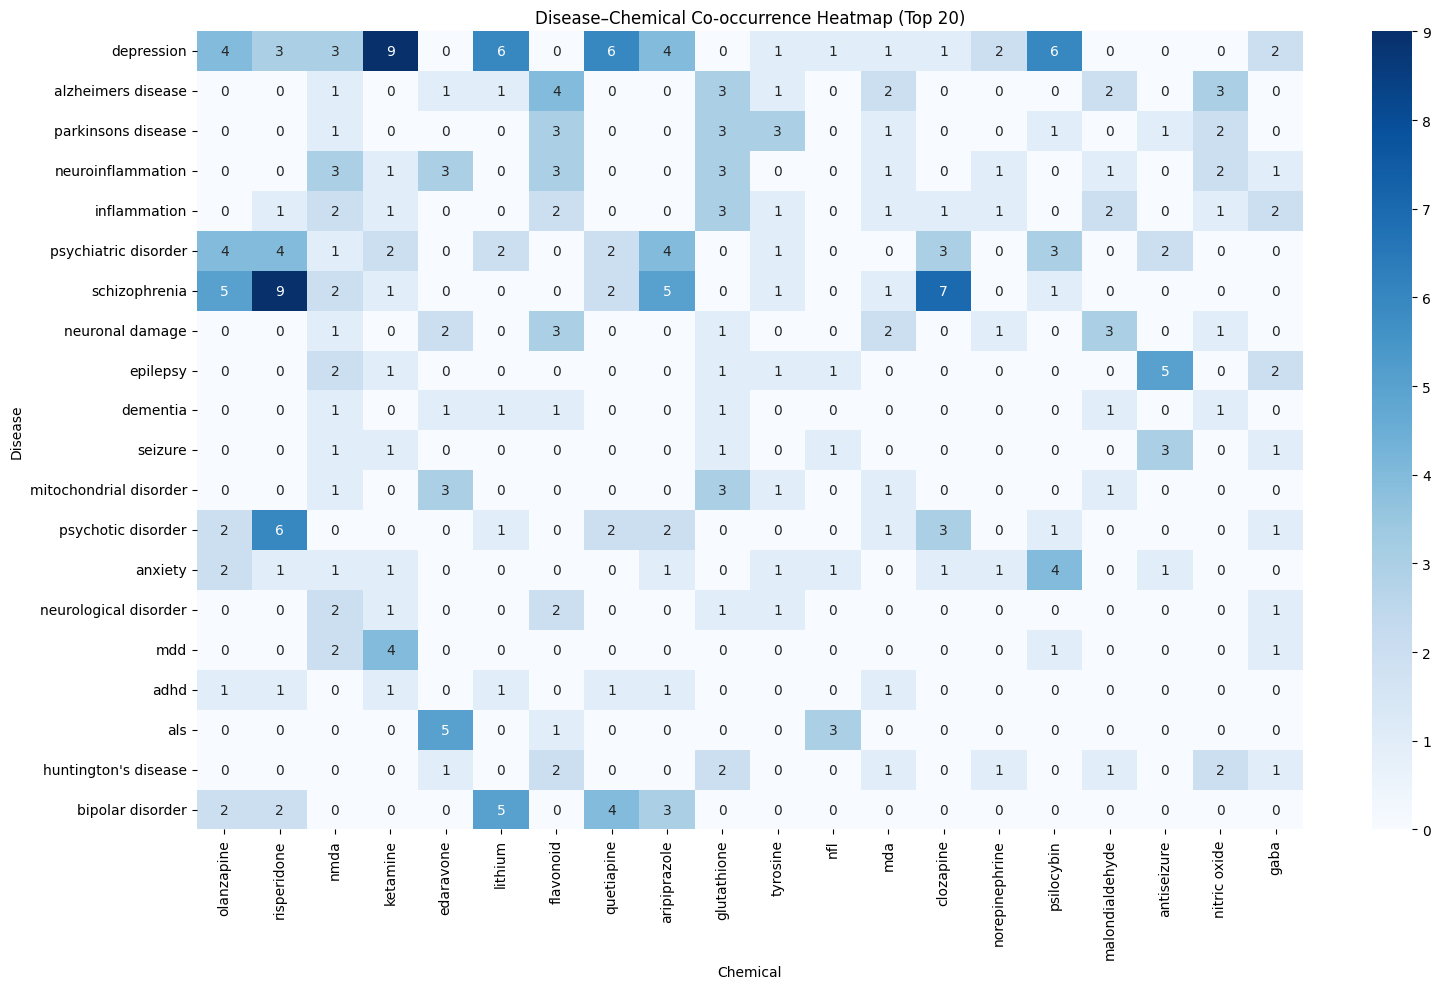

In [53]:
generic_chemicals = {'antidepressant', 'alcohol', 'smoking', 'smoke', 'nicotine', 'cigarette', 'tobacco', 'dopamine', 'glutamate', 'serotonin', 'calcium','ad', 'oxygen', 'amyloid beta', 'atp', 'steroid', 'superoxide'}
generic_diseases ={'cognitive decline', 'death', 'neurodegenerative disorder' }
# Build a list of all chemicals
all_chemicals = []
for entry in df['Chemicals'].dropna():
    all_chemicals.extend([c.strip() for c in entry.split(';') if c.strip()])

# Count occurrences
chemical_counts = Counter(all_chemicals)

# Find singleton chemicals
singleton_chemicals = {chem for chem, count in chemical_counts.items() if count == 1}


def filter_chemicals(chem_str):
    if pd.isna(chem_str) or not chem_str.strip():
        return ''
    chems = [c.strip() for c in chem_str.split(';') if c.strip()]
    # Remove singletons and generic chemicals
    filtered = [c for c in chems if c not in singleton_chemicals and c.lower() not in generic_chemicals]
    return '; '.join(filtered)

def filter_diseases(disease_str):
    if pd.isna(disease_str) or not disease_str.strip():
        return ''
    diseases = [d.strip() for d in disease_str.split(';') if d.strip()]
    # Remove generic diseases
    filtered = [d for d in diseases if d.lower() not in generic_diseases]
    return '; '.join(filtered)


# Apply the filter
df['Chemicals'] = df['Chemicals'].apply(filter_chemicals)
df['Diseases'] = df['Diseases'].apply(filter_diseases)

disease_chem_pairs = []

for _, row in df.iterrows():
    diseases = [d.strip() for d in str(row['Diseases']).split(';') if d.strip()]
    chemicals = [c.strip() for c in str(row['Chemicals']).split(';') if c.strip()]
    # Only consider rows with both at least one disease and one chemical
    for d, c in itertools.product(diseases, chemicals):
        disease_chem_pairs.append((d, c))

# Count co-occurrences
pair_counts = Counter(disease_chem_pairs)

# Convert to DataFrame for heatmap
if pair_counts:
    pair_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count'])
    pair_df[['Disease', 'Chemical']] = pd.DataFrame(pair_df['Pair'].tolist(), index=pair_df.index)
    pivot = pair_df.pivot_table(index='Disease', columns='Chemical', values='Count', fill_value=0)

    # Optionally, filter to top N diseases/chemicals for visualization
    top_diseases = pivot.sum(axis=1).sort_values(ascending=False).head(20).index
    top_chemicals = pivot.sum(axis=0).sort_values(ascending=False).head(20).index
    filtered_pivot = pivot.loc[top_diseases, top_chemicals]

    plt.figure(figsize=(16, 10))
    sns.heatmap(filtered_pivot, annot=True, fmt='.0f', cmap='Blues')
    plt.title('Disease–Chemical Co-occurrence Heatmap (Top 20)')
    plt.ylabel('Disease')
    plt.xlabel('Chemical')
    plt.tight_layout()
    plt.show()
else:
    print("No disease–chemical pairs found after filtering.")


In [55]:
import re

def keyword_match(text, keywords):
    if pd.isna(text):
        return 0
    text = text.lower()
    return int(any(kw in text for kw in keywords))

# Define keyword sets for each label
EFFICACY_KEYWORDS = [
    'efficacy', 'effective', 'improve', 'improved', 'improvement', 'benefit', 'response', 'outcome', 'therapeutic',
    'treatment', 'ameliorate', 'reduce', 'reduction', 'remission', 'relief', 'success', 'positive effect', 'clinical benefit'
]
SIDE_EFFECTS_KEYWORDS = [
    'side effect', 'adverse', 'toxicity', 'tolerability', 'tolerated', 'safety', 'harm', 'complication', 'risk', 'risk factor',
    'negative effect', 'unwanted effect', 'tolerable', 'intolerable', 'withdrawal', 'discontinue', 'discontinuation',
    'mortality', 'death', 'fatal', 'serious adverse', 'ae', 'sae'
]
MECHANISM_KEYWORDS = [
    'mechanism', 'mechanistic', 'pathway', 'modulate', 'modulation', 'inhibit', 'inhibition', 'activate', 'activation',
    'receptor', 'agonist', 'antagonist', 'blocker', 'mediated', 'signaling', 'cascade', 'target', 'pharmacodynamic',
    'pharmacokinetic', 'biomarker', 'expression', 'upregulate', 'downregulate', 'regulate', 'regulation', 'transduction',
    'binding', 'interact', 'interaction'
]

# Generate labels
df['Efficacy'] = df['Cleaned_Abstract'].apply(lambda x: keyword_match(x, [k.lower() for k in EFFICACY_KEYWORDS]))
df['Side_Effects'] = df['Cleaned_Abstract'].apply(lambda x: keyword_match(x, [k.lower() for k in SIDE_EFFECTS_KEYWORDS]))
df['Mechanism'] = df['Cleaned_Abstract'].apply(lambda x: keyword_match(x, [k.lower() for k in MECHANISM_KEYWORDS]))

# Show label distribution
print('Label counts:')
print('Efficacy:', df['Efficacy'].sum())
print('Side_Effects:', df['Side_Effects'].sum())
print('Mechanism:', df['Mechanism'].sum())

Label counts:
Efficacy: 584
Side_Effects: 371
Mechanism: 440


In [56]:
print(df[df['Efficacy'] == 1][['Cleaned_Abstract']].head())
print(df[df['Side_Effects'] == 1][['Cleaned_Abstract']].head())
print(df[df['Mechanism'] == 1][['Cleaned_Abstract']].head())

                                     Cleaned_Abstract
0   huntington disease hd neurodegenerative diseas...
8   parkinson disease pd progressive neurodegenera...
13  intermittent theta burst stimulation itbs noni...
18  alzheimer disease ad progressive neurodegenera...
20  expectancy violation propose potential core me...
                                     Cleaned_Abstract
8   parkinson disease pd progressive neurodegenera...
18  alzheimer disease ad progressive neurodegenera...
20  expectancy violation propose potential core me...
26  stroke lead cause long term disability death w...
32  pediatric status epilepticus require prompt re...
                                     Cleaned_Abstract
0   huntington disease hd neurodegenerative diseas...
8   parkinson disease pd progressive neurodegenera...
13  intermittent theta burst stimulation itbs noni...
18  alzheimer disease ad progressive neurodegenera...
20  expectancy violation propose potential core me...


## Data Labeling 
Known Drug List + PubChem API for Unknowns

In [57]:
MARKETED_DRUGS = {
    # Antidepressants
    'fluoxetine', 'sertraline', 'escitalopram', 'paroxetine', 'citalopram', 'duloxetine', 'venlafaxine', 'bupropion',
    # Antipsychotics
    'risperidone', 'olanzapine', 'quetiapine', 'clozapine', 'aripiprazole', 'haloperidol', 'paliperidone', 'ziprasidone',
    # Mood stabilizers
    'lithium', 'valproate', 'lamotrigine', 'carbamazepine',
    # Antianxiety
    'alprazolam', 'diazepam', 'lorazepam', 'buspirone',
    # ADHD
    'methylphenidate', 'atomoxetine', 'lisdexamfetamine', 'guanfacine',
    # Alzheimer's
    'donepezil', 'memantine', 'galantamine', 'rivastigmine',
    # Parkinson's
    'levodopa', 'carbidopa', 'safinamide', 'rasagiline', 'amantadine',
    # Pain/Neurology
    'gabapentin', 'pregabalin', 'topiramate', 'levetiracetam',
    # Others
    'ketamine', 'psilocybin', 'naltrexone', 'metformin', 'aspirin', 'acetaminophen'
}

class HybridDrugChecker:
    def __init__(self):
        self.cache_file = "hybrid_drug_cache.pkl"
        self.cache = self._load_cache()
        
    def _load_cache(self) -> Dict[str, bool]:
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, 'rb') as f:
                    return pickle.load(f)
            except:
                return {}
        return {}
    
    def _save_cache(self):
        with open(self.cache_file, 'wb') as f:
            pickle.dump(self.cache, f)
    
    def check_pubchem_drug_status(self, chemical_name: str) -> bool:
        """
        Improved PubChem check with better drug detection logic
        """
        try:
            # Search for the compound
            search_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/cids/JSON"
            response = requests.get(search_url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                cids = data.get('InformationList', {}).get('Information', [{}])[0].get('CID', [])
                
                if cids:
                    cid = cids[0]
                    
                    # Get more detailed information
                    detail_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight,CanonicalSMILES,IUPACName,XLogP,HBondDonorCount,HBondAcceptorCount,TPSA,Complexity/JSON"
                    
                    detail_response = requests.get(detail_url, timeout=10)
                    
                    if detail_response.status_code == 200:
                        detail_data = detail_response.json()
                        properties = detail_data.get('PropertyTable', {}).get('Properties', [{}])[0]
                        
                        # More sophisticated drug-likeness check
                        mol_weight = properties.get('MolecularWeight', 0)
                        logp = properties.get('XLogP', 0)
                        hbd = properties.get('HBondDonorCount', 0)
                        hba = properties.get('HBondAcceptorCount', 0)
                        tpsa = properties.get('TPSA', 0)
                        
                        # Enhanced drug-likeness criteria
                        is_drug_like = (
                            150 <= mol_weight <= 500 and  # Reasonable molecular weight
                            -2 <= logp <= 5 and           # Reasonable lipophilicity
                            hbd <= 5 and                  # Not too many H-bond donors
                            hba <= 10 and                 # Not too many H-bond acceptors
                            tpsa <= 140                   # Not too polar
                        )
                        
                        # Check for FDA/medical indicators in the name
                        name_lower = chemical_name.lower()
                        medical_indicators = [
                            'fda', 'approved', 'usp', 'nf', 'marketed', 'commercial',
                            'tablet', 'capsule', 'injection', 'solution', 'hydrochloride',
                            'sulfate', 'citrate', 'acetate', 'phosphate'
                        ]
                        has_medical_indicators = any(indicator in name_lower for indicator in medical_indicators)
                        
                        return is_drug_like or has_medical_indicators
            
            return False
            
        except Exception as e:
            print(f"PubChem API error for {chemical_name}: {e}")
            return False
    
    def check_drug_status(self, chemical_name: str) -> bool:
        """
        Hybrid approach: Check known list first, then PubChem for unknowns
        """
        chemical_lower = chemical_name.lower()
        
        # Check cache first
        if chemical_lower in self.cache:
            return self.cache[chemical_lower]
        
        # Check known drug list first (fast and reliable)
        if chemical_lower in MARKETED_DRUGS:
            self.cache[chemical_lower] = True
            self._save_cache()
            return True
        
        # If not in known list, try PubChem API
        pubchem_result = self.check_pubchem_drug_status(chemical_name)
        self.cache[chemical_lower] = pubchem_result
        self._save_cache()
        
        return pubchem_result
    
    def get_cache_stats(self):
        total = len(self.cache)
        marketed = sum(self.cache.values())
        return {
            'total_checked': total,
            'marketed_drugs': marketed,
            'non_marketed': total - marketed,
            'cache_hit_rate': f"{len([k for k in self.cache.keys() if k in MARKETED_DRUGS]) / len(MARKETED_DRUGS) * 100:.1f}%"
        }

# Initialize the hybrid checker
hybrid_checker = HybridDrugChecker()

# Function to check if any chemical in a string is a marketed drug
def has_marketed_drug_hybrid(chem_str: str) -> int:
    """Hybrid approach to check for marketed drugs"""
    if pd.isna(chem_str) or not chem_str.strip():
        return 0
    
    chemicals = [c.strip() for c in chem_str.split(';') if c.strip()]
    
    for chem in chemicals:
        if hybrid_checker.check_drug_status(chem):
            return 1
        time.sleep(0.2)  # Rate limiting
    
    return 0

# Test the hybrid approach
print("Testing Hybrid Approach...")
test_chemicals = ["fluoxetine", "water", "aspirin", "unknown_chemical", "risperidone"]
for chem in test_chemicals:
    result = hybrid_checker.check_drug_status(chem)
    print(f"{chem}: {'Marketed Drug' if result else 'Not a marketed drug'}")

# Apply to your DataFrame
print("\nApplying hybrid approach to your dataset...")
df['Has_Marketed_Drug'] = df['Chemicals'].apply(has_marketed_drug_hybrid)

# Show results
print(f"Abstracts with marketed drugs: {df['Has_Marketed_Drug'].sum()}")
print(f"Cache stats: {hybrid_checker.get_cache_stats()}")


Testing Hybrid Approach...
fluoxetine: Marketed Drug
water: Not a marketed drug
aspirin: Marketed Drug
unknown_chemical: Not a marketed drug
risperidone: Marketed Drug

Applying hybrid approach to your dataset...
Abstracts with marketed drugs: 119
Cache stats: {'total_checked': 720, 'marketed_drugs': 36, 'non_marketed': 684, 'cache_hit_rate': '76.6%'}


In [58]:
df.sample(15)


,PMID,Title,Abstract,Journal,Year,Authors,Cleaned_Abstract,Categories,Research_Type,Diseases,Chemicals,Efficacy,Side_Effects,Mechanism,Has_Marketed_Drug
692,40025010,Lack of association between pretreatment gluta...,Studies have shown gamma-amino-butyric acid (G...,Translational psychiatry,2025.0,Feiyang Dai; Kenneth Wengler; Xiang He; Junyin...,study show gamma amino butyric acid gaba glx c...,depressive disorder; mdd; depression; gamma-am...,clinical_trial,depression; mdd,gaba; glutamine; escitalopram,1,0,1,1
1233,39662163,RENEWED: A follow-up study of the opicinumab p...,"The randomized, phase 2 RENEW trial (NCT017211...",Multiple sclerosis and related disorders,2025.0,Orhan Aktas; Focke Ziemssen; Tjalf Ziemssen; A...,randomize phase 2 renew trial nct01721161 eval...,first-episode unilateral acute optic neuritis;...,clinical_trial,first-episode unilateral acute optic neuriti; ...,methylprednisolone,1,1,0,0
240,40340017,Extracellular vesicles as a promising tool in ...,This review deals with the application of extr...,Progress in neuro-psychopharmacology & biologi...,2025.0,Nikola Balic; Matea Nikolac Perkovic; Tina Mil...,review deal application extracellular vesicle ...,various neuropsychiatric disorders; mood disor...,review,various neuropsychiatric disorder; mood disord...,,1,1,1,0
51,40512701,Optimizing Treatment With Aripiprazole Monohyd...,Schizophrenia and bipolar I disorder (BP-I) ar...,The Journal of clinical psychiatry,2025.0,Joseph F Goldberg; Eric D Achtyes; Christoph U...,schizophrenia bipolar disorder bp chronic disa...,schizophrenia; bipolar i disorder; bp-i; psych...,review,schizophrenia; bipolar disorder; bp-i; psychia...,aripiprazole,1,1,1,1
285,40299101,Unraveling the role of CGRP in neurological di...,"Alzheimer's disease (AD), Parkinson's disease ...",Molecular biology reports,2025.0,Sampriti Sarkar; Pratyush Porel; Sourabh Kosey...,alzheimer disease ad parkinson disease pd hunt...,alzheimer's disease; ad; parkinson's disease; ...,review,alzheimers disease; parkinsons disease; huntin...,cgrp,1,1,1,0
1548,39454213,Endoscopic transorbital approach for resection...,The endoscopic transorbital approach (ETOA) ha...,Journal of neurosurgery,2025.0,Chiman Jeon; Chang-Ki Hong; Kyuha Chong; Won J...,endoscopic transorbital approach etoa emerge p...,glioma; cavernous malformation; glioblastoma m...,review,glioma/glioblastoma; cavernous malformation; m...,,1,1,1,0
897,39893013,Preclinical evaluation of MK-8189: A novel pho...,MK-8189 is a novel phosphodiesterase 10A (PDE1...,The Journal of pharmacology and experimental t...,2025.0,Sean M Smith; Dawn Toolan; Monika Kandebo; Jos...,mk-8189 novel phosphodiesterase 10a pde10a inh...,schizophrenia; deficit in prepulse inhibition;...,clinical_trial,schizophrenia; deficit in prepulse inhibition;...,guanosine monophosphate,1,1,1,0
805,39953286,Preventing psychosis in people at clinical hig...,Recently published large-scale randomised cont...,Molecular psychiatry,2025.0,Amedeo Minichino; Cathy Davies; Olga Karpenko;...,recently publish large scale randomise control...,psychosis; omega-3 fatty acids; risperidone; m...,clinical_trial; review,psychotic disorder,omega-3 fatty acid; risperidone; minocycline,1,1,1,1
1071,39762986,Polysomnographic titration of non-invasive ven...,Non-invasive ventilation (NIV) uses positive p...,Trials,2025.0,David J Berlowitz; Dominic Rowe; Mark E Howard...,non invasive ventilation niv use positive pres...,respiratory muscle weakness; mnd; niv; clinica...,clinical_trial; observational,respiratory muscle weakness; mnd,niv,1,0,0,0
555,40120616,Safety and efficacy of long-term gantenerumab ...,Amyloid plaque removal by monoclonal antibody ...,The Lancet. Neurology,2025.0,Randall J Bateman; Yan Li; Eric M McDade; Jorg...,amyloid plaque removal monoclonal antibody the...,alzheimer's disease; dominantly inherited alzh...,clinical_trial,alzheimers disease; dominantly inherited alzhe...,amyloid,1,1,0,0


In [59]:
df.to_csv('cleaned_for_modeling.csv', index=False)
print(f"Saved filtered data with {len(df)} rows to cleaned_for_modeling.csv")

Saved filtered data with 598 rows to preprocessing/cleaned_for_modeling.csv
